#Descrição do Código
Entrada do Grafo:

O grafo é definido com 5 nós, cada um com duas features (densidade_populacional e índice_criminalidade).
As arestas são representadas pela matriz edge_index.
Modelo:

Usamos duas camadas GCN (GCNConv):
A primeira camada transforma as features de 2 para 4 dimensões.
A segunda camada reduz para 2 dimensões, representando as classes de saída.
Treinamento:

O modelo é treinado por 100 épocas usando Adam como otimizador.
A função de perda usada é negative log likelihood loss (F.nll_loss).
Avaliação:

Após o treinamento, o modelo faz predições para os nós.
O desempenho é medido pela acurácia.

In [ ]:
pip install torch torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 2.4 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Criando um grafo fictício
# Nós: 5 locais; Arestas: conexões entre os locais
# Features dos nós: [densidade populacional, índice de criminalidade]
# Labels dos nós: 0 (Zona Segura) ou 1 (Zona Crítica)

# Matriz de adjacência (arestas entre nós)
edge_index = torch.tensor([
    [0, 1, 2, 3, 4, 0, 2, 3],  # De
    [1, 0, 3, 4, 0, 2, 3, 1]   # Para
], dtype=torch.long)

# Features dos nós (densidade_populacional, índice_criminalidade)
x = torch.tensor([
    [1, 0.5],  # Nó 0
    [0.8, 0.2],  # Nó 1
    [0.7, 0.6],  # Nó 2
    [0.3, 0.9],  # Nó 3
    [0.4, 0.7]   # Nó 4
], dtype=torch.float)

# Labels dos nós (0: Zona Segura, 1: Zona Crítica)
y = torch.tensor([0, 0, 1, 1, 1], dtype=torch.long)

# Criando o objeto de dados do grafo
data = Data(x=x, edge_index=edge_index, y=y)

# Definindo a Graph Neural Network
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(2, 4)  # Converte features de 2 para 4 dimensões
        self.conv2 = GCNConv(4, 2)  # Converte de 4 para 2 (saída: 2 classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)  # Função de ativação ReLU
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Probabilidade logarítmica

# Treinando o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Loop de treinamento
model.train()
for epoch in range(100):  # 100 épocas
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)  # Função de perda
    loss.backward()
    optimizer.step()

# Avaliando o modelo
model.eval()
_, pred = model(data).max(dim=1)  # Predições
correct = (pred == data.y).sum().item()
accuracy = correct / data.num_nodes
print(f"Acurácia: {accuracy * 100:.2f}%")

# Resultado: Predições de classificação de cada nó
print(f"Labels verdadeiros: {data.y.tolist()}")
print(f"Predições do modelo: {pred.tolist()}")


Acurácia: 60.00%
Labels verdadeiros: [0, 0, 1, 1, 1]
Predições do modelo: [1, 1, 1, 1, 1]


#Explicação
Entrada de Dados:

Os atributos dos nós são [renda média, desemprego, criminalidade].
Os rótulos indicam se o distrito é seguro ou crítico.
Estrutura do Modelo:

GCNConv é usada para combinar as informações dos nós e seus vizinhos.
Primeira camada: transforma os atributos em uma representação intermediária de 4 dimensões.
Segunda camada: reduz para 2 dimensões correspondentes às classes (0 ou 1).
Treinamento:

O modelo é treinado por 100 épocas para minimizar a entropia cruzada entre as predições e os rótulos reais.
Avaliação:

Após o treinamento, o modelo faz predições e calcula a acurácia.
Visualização:

O grafo é visualizado com os nós coloridos:
Verde para "Zona Segura".
Vermelho para "Zona Crítica".

Época 20, Loss: 139.2163
Época 40, Loss: 12.7038
Época 60, Loss: 9.2250
Época 80, Loss: 9.3913
Época 100, Loss: 7.7195
Acurácia: 50.00%


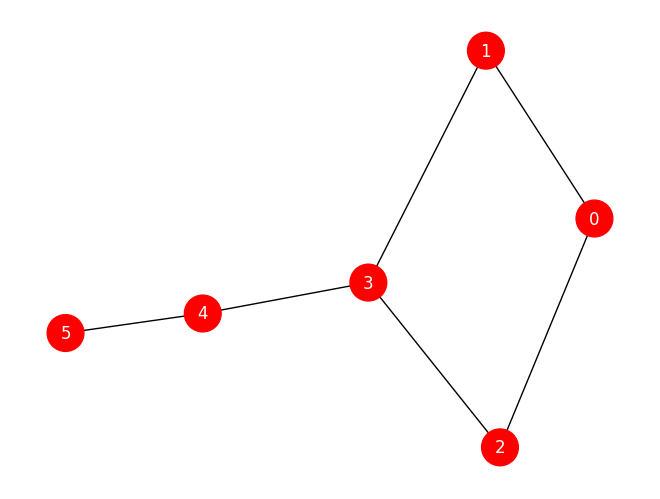

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import networkx as nx
import matplotlib.pyplot as plt

# Simulação de um grafo com 6 distritos
# Cada nó tem características: [renda média, desemprego, criminalidade]
features = torch.tensor([
    [5000, 5, 30],  # Distrito 1
    [6000, 4, 20],  # Distrito 2
    [4000, 7, 50],  # Distrito 3
    [4500, 6, 45],  # Distrito 4
    [8000, 3, 15],  # Distrito 5
    [3000, 8, 60]   # Distrito 6
], dtype=torch.float)

# Classes: 0 = Zona Segura, 1 = Zona Crítica
labels = torch.tensor([0, 0, 1, 1, 0, 1], dtype=torch.long)

# Conexões entre distritos (arestas do grafo)
edge_index = torch.tensor([
    [0, 1, 0, 2, 1, 3, 2, 3, 3, 4, 4, 5],  # Fonte (from)
    [1, 0, 2, 0, 3, 1, 3, 2, 4, 3, 5, 4]   # Destino (to)
], dtype=torch.long)

# Criando o grafo com PyTorch Geometric
data = Data(x=features, edge_index=edge_index, y=labels)

# Definindo a GNN
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels=3, out_channels=4)  # Entrada -> 4 dimensões
        self.conv2 = GCNConv(in_channels=4, out_channels=2)  # 4 dimensões -> 2 classes

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # Primeira camada: Convolução GCN + ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Segunda camada: Convolução GCN
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)  # Probabilidades logarítmicas para classificação

# Treinando o modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GNN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out, data.y)
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f'Época {epoch+1}, Loss: {loss.item():.4f}')

# Avaliação
model.eval()
out = model(data)
pred = out.argmax(dim=1)
accuracy = (pred == data.y).sum().item() / data.num_nodes
print(f'Acurácia: {accuracy * 100:.2f}%')

# Visualizando o grafo com as classificações
G = nx.Graph()
edges = edge_index.t().tolist()
G.add_edges_from(edges)

color_map = ['green' if label == 0 else 'red' for label in pred.tolist()]
nx.draw(G, with_labels=True, node_color=color_map, node_size=700, font_color='white')
plt.show()


#viaturas necessarias por dia

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Simulação de dados
data = pd.DataFrame({
    'populacao': [1000, 2000, 1500, 800, 3000],
    'crimes_horario': [5, 20, 10, 2, 50],
    'luminosidade': [0.2, 0.8, 0.6, 0.1, 0.9],  # 0 (muito escuro) a 1 (bem iluminado)
    'frequencia_viaturas': [1, 3, 2, 1, 4],
    'viaturas_necessarias': [2, 5, 3, 1, 6]  # Target
})

# Divisão em features e target
X = data[['populacao', 'crimes_horario', 'luminosidade', 'frequencia_viaturas']]
y = data['viaturas_necessarias']

# Separar dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Treinar o modelo
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Previsão
y_pred = model.predict(X_test)

# Avaliação
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE do modelo: {rmse}")

# Prevendo para novos dados
novo_dado = pd.DataFrame({
    'populacao': [2500],
    'crimes_horario': [15],
    'luminosidade': [0.5],
    'frequencia_viaturas': [2]
})
previsao = model.predict(novo_dado)
print(f"Viaturas sugeridas: {previsao[0]:.2f}")


RMSE do modelo: 1.54
Viaturas sugeridas: 3.37


In [ ]:
import folium

# Simulação de bairros e previsão
bairros = {
    'Bairro A': [-23.5505, -46.6333],  # São Paulo (exemplo)
    'Bairro B': [-23.5629, -46.6544],
    'Bairro C': [-23.5735, -46.6417],
}
previsoes = [3, 5, 2]

mapa = folium.Map(location=[-23.5505, -46.6333], zoom_start=12)
for (bairro, coord), viaturas in zip(bairros.items(), previsoes):
    folium.CircleMarker(
        location=coord,
        radius=viaturas * 2,  # Aumenta tamanho proporcional
        color='red' if viaturas > 3 else 'blue',
        fill=True,
        fill_opacity=0.7,
        popup=f"{bairro}: {viaturas} viaturas sugeridas"
    ).add_to(mapa)

mapa
